# Assignment 2: Classical Control
Name: Yun-Yi Chiu

Purdue Username: chiu93


In this assignment, you will implement and tune a trajectory following controller for a 2-degree of freedom(DoF) robotic arm, and (optionally) a race car.

## Getting Started

We'll be using OpenAI gym, along with PyBullet, to model the robot's environment.
- [OpenAI gym](https://gym.openai.com/) is a toolkit for developing planning and control algorithms. It provides a standard API that abstracts away the model of the robot's environment. It is primarily used for reinforcement learning agents, but can work with any controller, including the PD controllers you'll build in this assignment.
  - If you've never used gym, be sure to read this short [tutorial](https://gym.openai.com/docs/) before getting started.
- [PyBullet](https://pybullet.org/wordpress/) is an open-source physics engine that we'll use to model the robot.
- [pybullet-gym](https://github.com/benelot/pybullet-gym) is an open-source library that implements a variety of gym environments using PyBullet as the backend. One of these environments is `ReacherPyBulletEnv-v0`, the robotic arm that you'll be working with.

## Installation Instructions
Before running this notebook, you'll need to install `gym` and `pybullet-gym`, like so:
```bash
~ # install gym
~ pip install gym
~ # install pybullet-gym
~ git clone https://github.com/benelot/pybullet-gym.git
~ cd pybullet-gym
~ pip install -e .
```

## Overview: 2-DOF robotic arm

In [1]:
# load libraries (if this fails, see "Installation Instructions")
import gym
import numpy as np
import pybulletgym.envs
import matplotlib.pyplot as plt
import pybullet

pybullet build time: Feb 12 2022 10:44:15


In [2]:
# initialize constants
l0 = 0.1
l1 = 0.11

In [3]:
# initialize the environment

# This try-except is to make sure there is only a single pybullet connection set-up
try:
    env.reset()
except NameError:
    env = gym.make("ReacherPyBulletEnv-v0")

env.render(mode="human")
obs = env.reset()

# while (pybullet.isConnected()):
#     pybullet.stepSimulation()

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/gym/spaces/box.py:73: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(


argv[0]=
Version = 4.1 ATI-4.5.14
Vendor = ATI Technologies Inc.
Renderer = AMD Radeon Pro Vega 20 OpenGL Engine
b3Printf: Selected demo: Physics Server
startThreads creating 1 threads.
starting thread 0
started thread 0 
MotionThreadFunc thread started


The robot arm you will be controlling looks like this:

![RobotArm](robotArm.png)

The base of the robot is at the origin; the links $l_0$ and $l_1$ are 0.1 and 0.11 units long respectively.

The action space of environment is [$\tau_0$,$\tau_1$], where $\tau_0$ and $\tau_1$ are the torques applied to joints $q_0$ and $q_1$ respectively.

Do _not_ use the observation space of the environment to get the robot's position. Instead, use the following class methods to obtain the joint angles:
```python
# To get the current position and angular velocity of q0
q0, q0_dot = env.unwrapped.robot.central_joint.current_position()
# To get the current position and angular velocity of q1
q1, q1_dot = env.unwrapped.robot.elbow_joint.current_position()

# To set joint q0 to a particular position. (Use only before running your controller, to initialize the start position)
env.unwrapped.robot.central_joint.reset_position(position, 0)
# To set joint q1 to a particular position. (Use only before running your controller, to initialize the start position)
env.unwrapped.robot.elbow_joint.reset_position(position, 0)
```

Your job is to implement PD controllers that track the trajectory

$$\begin{bmatrix}x(\theta) \\ y(\theta)\end{bmatrix}
= \begin{bmatrix}(0.19 + 0.02 \cos 4\theta)\cos\theta \\ (0.19 + 0.02 \cos 4\theta)\sin\theta\end{bmatrix},
\text{ for }\theta \in [-\pi, \pi]$$

This trajectory is plotted below:

In [4]:
x = [(0.19 + 0.02 * np.cos(theta * 4)) * np.cos(theta) for theta in np.arange(-np.pi, np.pi, 0.001)]
y = [(0.19 + 0.02 * np.cos(theta * 4)) * np.sin(theta) for theta in np.arange(-np.pi, np.pi, 0.001)]
# plt.plot(x, y, 'b')
# plt.axis('equal')
# plt.show()
# plt.savefig('arm_traj.png')
traj = list(zip(x,y))

### 1. Forward Model 

Derive the forward model for the robot as a closed-form expression expressed in joint angles and link length:

$$f\left(\begin{bmatrix}q_0 \\ q_1\end{bmatrix}\right) =
\begin{bmatrix}
% your answer here
\underline{\;\;\;\;} \\
\underline{\;\;\;\;}
\end{bmatrix}
= \begin{bmatrix} x \\ y\end{bmatrix}$$

Using the robot model parameters, write a function `getForwardModel` that takes the joint states and returns the end-effector position.

In [5]:
def getForwardModel(q0, q1):
    x = l0 * np.cos(q0) + l1 * np.cos(q0 + q1)
    y = l0 * np.sin(q0) + l1 * np.sin(q0 + q1)

    return np.array([x, y])
    # raise NotImplementedError

### 2. Jacobian

Derive the expression for the Jacobian of the robot:

$$J_f(q_0, q_1) = \begin{bmatrix}
\underline{\;\;\;\;} % your answer here
\end{bmatrix}$$

Write a function `getJacobian` that takes the joint states and returns the Jacobian.

In [6]:
def getJacobian(q0, q1):
    jacobian = np.array([
        [-l0 * np.sin(q0) - l1 * np.sin(q0 + q1), -l1 * np.sin(q0 + q1)],
        [l0 * np.cos(q0) + l1 * np.cos(q0 + q1), l1 * np.cos(q0 + q1)]
    ])
    
    return jacobian
    # raise NotImplementedError

### 3. X-Y controller

**Background:** for reasons beyond the scope of this course, it so happens that, for any robot,
$$\vec \tau = J^T \vec F,$$
where
- $\vec F = \langle F_x, F_y \rangle$ is the force vector exerted by the robot at the end effector
- $\vec \tau = \langle \tau_0, \tau_1 \rangle$ is the vector of torques exerted by the joints
- $J$ is the Jacobian matrix at the current position.

Use this fact to implement a closed-loop PD controller that controls the robot along the trajectory `traj`, using the error in the end-effector as the input signal. Your controller should compute forces $F_x$ and $F_y$, and then use `getJacobian` along with the above equation to translate them into joint torques.

Plot the trajectory of the robot juxtaposed over the desired trajectory, and calculate the mean square error between both paths. Also plot the errors with respect to time, and use those plots to tune your controller.

**Note: Initialize the robot arm to $q_0=\pi$ and $q_1=0$**

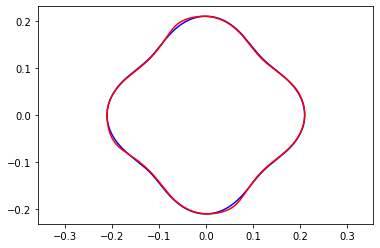

mse_x: 7.621621755142144e-07
mse_y: 3.3146362119559844e-06


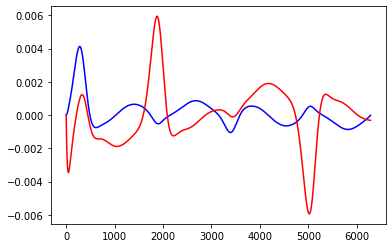

<Figure size 432x288 with 0 Axes>

In [7]:
# Write your script here
# OK 1. Implement a closed-looped PD controller that controls the robot along the traj.
# OK 2. Use the error in the end-effector as input: Error here is (ex, ey) = (tx-x, ty-y).
# OK 3. PD controller should compute Forces Fx and Fy.
# OK 4. Use getJacobian and the given equation to translate them into joint torques
# OK 5. Plot the trajectory of the robot.
# OK 6. Calculate the mean square error.
# OK 7. Plot the errors with repect to time.
# OK 8. Use the two plots to tune the PD controller.

# Resetting q0 to pi and q1 to 0
env.unwrapped.robot.central_joint.reset_position(np.pi, 0) # reset_position(position, velocity)
env.unwrapped.robot.elbow_joint.reset_position(0, 0)

# PD controller gains (kp=0.8125 works ok)
# 1 Good combo
# kp = 0.8125
# kd = 20

# 2 Halved kp - NG
# kp = 0.40625
# kd = 20

# 3 Halved kp doubled kd - NG
# kp = 0.40625
# kd = 40

# 4 Doubled kd - Better than 1
# kp = 0.8125
# kd = 40

# 5 Tripled kd - Second best
# kp = 0.8125
# kd = 60

# 6 Increased kp - Too much, worse than 5
# kp = 0.9
# kd = 60

# 7 Increased kp by less. kp=(trial 5 + trial 6)/2 - Better than 6, still worse than 5
# kp = 0.85625
# kd = 60

# 8 Decreased kp - Best so far!
# kp = 0.8
# kd = 60

# 9 Decreased kp - Best so far!
kp = 0.8
kd = 80

prev_err = np.array([0., 0.]);
errors_x = []
errors_y = []
actual_x = []
actual_y = []

# while (pybullet.isConnected()):
for step in range(len(traj)):
    q0, q0_dot = env.unwrapped.robot.central_joint.current_position()
    q1, q1_dot = env.unwrapped.robot.elbow_joint.current_position()

    # end effector's current position
    curr_pos = getForwardModel(q0, q1);
    actual_x.append(curr_pos[0])
    actual_y.append(curr_pos[1])

    # effector's target position
    targ_pos = traj[step]

    # error based on difference in position
    err = targ_pos-curr_pos
    errors_x.append(err[0])
    errors_y.append(err[1])

    # PD controller
    force = kp * err + kd * (err - prev_err)

    prev_err = err

    # calculate Jacobian transpose
    j = getJacobian(q0, q1)
    jT = j.transpose()
    
    # calculate torque
    tau = np.dot(jT, force)

    # apply torque to joints
    env.step(tau)

plt.plot(x, y, 'b', actual_x, actual_y, 'r')
plt.axis('equal')
plt.savefig('arm_traj.png')
plt.show()
plt.clf()

mse_x = np.square(np.subtract(x, actual_x)).mean()
mse_y = np.square(np.subtract(y, actual_y)).mean()
print(f"mse_x: {mse_x}")
print(f"mse_y: {mse_y}")

plt.plot(np.arange(0, len(errors_x)), errors_x, 'b', np.arange(0, len(errors_y)), errors_y, 'r')
plt.savefig('err_v_iter.png')
plt.show()
plt.clf()

### 4. Inverse Kinematics

Using the functions `getForwardModel` and `getJacobian` from parts 1 and 2, write a function `getIK` that takes the current end-effector position, target end-effector position, and current joint states; and returns the target joint-states.

In [8]:
def getIK(current_position, target_position, current_state):
    # x, y = current_position
    # tx, ty = target_position
    q0 = current_state[0]
    q1 = current_state[1]

    j = getJacobian(q0, q1)
    pinvj = np.linalg.pinv(j)

    target_state = np.dot(pinvj, (target_position - current_position))

    return target_state
    # raise NotImplementedError

Now derive the analytical inverse kinematic solution; i.e. solve the problem using a closed-form equation, rather than an iterative method. _Show your work_. Correct answers without derivations will not receive full credit.
\begin{align*}
    % your derivations here
    q_0 &= \underline{\;\;\;\;} \\
    q_1 &= \underline{\;\;\;\;}
\end{align*}

Explain what challenges there would be to use the analytical IK solution to track trajectories:

_<your explanation here\>_

### 5. IK controller

Implement a closed-loop PD controller that controls the robot along the trajectory `traj`, using the error in the joint-angles as the input signal.

Plot the trajectory of the robot juxtaposed over the actual trajectory and caluclate the mean square error between both paths. Also plot the errors with respect to time, and use those plots to tune your controller.

**Note: Initialize the robot arm to $q_0=\pi$ and $q_1=0$**

In [9]:
# Write your script here.
# while (pybullet.isConnected()):
#     pybullet.stepSimulation()

### 6. (Optional) Race Car

**Note:** this exercise is optional. If you choose to participate, you will compete with other students to design the best controller for a race car environment. The winner will receive 10 bonus points.

The objective of the `racecar` environment is to make the race car travel as far as possible on a track within the given time. There are 3 tracks vailable: `FigureEight`, `Linear`, and `Circle` (default).
Each track has a different shape, time limit, and horizon length. To set up an environment with a particular track, you can pass the track name while instantiating the environment. For example, to set up the figure eight trajectory:

```python
from racecar.SDRaceCar import SDRaceCar
env = SDRaceCar(render_env=True, track='FigureEight')
```

To install the race car environment, run the following commands:
```bash
~ git clone https://github.com/ucsdarclab/RaceCar.git
~ cd RaceCar
~ pip install -e .
```

The action space of the environment consists of [wheel angle, thrust]. The range of both these values are normalized to be between $\pm 1$.The observation space consists of [$x, y, \theta, v_x, v_y, \dot\theta, h$], where ($x, y, \theta$) is the intertial frame position of the car; $v_x, v_y$ are the longitudinal and lateral velocities  respectively; and $\dot\theta$ is the yaw rate. $h$ is the co-ordinate on the track the car has to reach.

At each time step, the race car environment gives a reward that is proportional to the speed of the car and its proximity to the track. It terminates (`done = True`) after a fixed amount of time, or if the car gets too far from the track.

Using these observations implement a controller that can traverse all three tracks. You may use different gains for different tracks, but the controller itself must be the same. Record the cumulative reward for each track; these rewards will be summed together to create your controller's score. If your controller has the highest score, you win!

_Tip:_ if you call `env.render()` at each step to visualize the car's path, you may find that Jupyter interprets each step as a separate image. To avoid this, try running
```IPython
%matplotlib tk # others include qt, wx, gtk, osx
```
to load results as animations in a separate window. You may have to experiment with several different backends to find the one that works best with your system.

In [10]:
from racecar.SDRaceCar import SDRaceCar

ModuleNotFoundError: No module named 'racecar'

In [ ]:
# define your controller here

In [ ]:
rc_env = SDRaceCar(render_env=True,track='Circle')
# run your controller for the 'Circle' environment


In [ ]:
rc_env = SDRaceCar(render_env=True,track='Linear')
# run your controller for the 'Linear' environment


In [ ]:
rc_env = SDRaceCar(render_env=True,track='FigureEight')
# run your controller for the 'FigureEight' environment
